## Differential Photometry

First, we load one of the science frames to highlight the selected stars, the parameter of the sky annulus, the chosen aperture and so on.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
import pickle
import matplotlib.colors as colors

science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
science_frame_name = './group10_WASP-135_20190803/correct/' + science_list[0][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

The two following functions have been taken from the preivous lectures.

In [11]:
def make_annulus_around_star(x_pos, y_pos, inner_radius, outer_radius, label='', color='y'):
    from matplotlib.patches import Circle

    n, radii = 50, [inner_radius, outer_radius]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)


def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)


We gather the coordinates for the target and reference stars from the previous lectures:

 - x_target = 228
 - y_target = 33

 - x_reference_01 = 146
 - y_reference_01 = 21

 - x_reference_02 = 194
 - y_reference_02 = 62

 - x_reference_03 = 290
 - y_reference_03 = 93

 - x_reference_04 = 322
 - y_reference_04 = 40

vmin:  1067.9    vmax: 110239.3


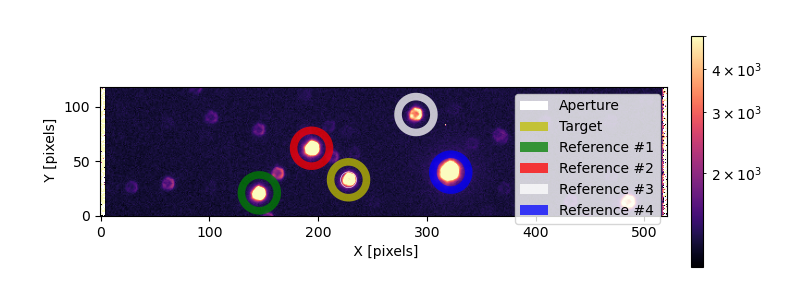

In [12]:
x_target = 228
y_target = 33

x_reference_01 = 146
y_reference_01 = 21

x_reference_02 = 194
y_reference_02 = 62

x_reference_03 = 290
y_reference_03 = 93

x_reference_04 = 322
y_reference_04 = 40

aperture = 7 #6 8
inner_radius = 13
outer_radius = 20

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, aperture, label='Aperture')

make_annulus_around_star(x_target, y_target, inner_radius, outer_radius, label='Target')
make_annulus_around_star(x_reference_01, y_reference_01, inner_radius, outer_radius, label='Reference #1', color='g')
make_annulus_around_star(x_reference_02, y_reference_02, inner_radius, outer_radius, label='Reference #2', color='r')
make_annulus_around_star(x_reference_03, y_reference_03, inner_radius, outer_radius, label='Reference #3', color='w')
make_annulus_around_star(x_reference_04, y_reference_04, inner_radius, outer_radius, label='Reference #4', color='b')
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

### Importing the *AperturePhotometry* class

We now use the **Aperture Photometry** class to perform aperture photometry on the target and reference stars. We select the a maximum of three reference stars so *Reference #4* will not be utilised as it is too bright in fact. In the previous analysis we selected 6 as the ideal aperture, and 13-20 as inner and outer radii.

In [13]:
from aperture_photometry import AperturePhotometry

aperture = 6
inner_radius = 13
outer_radius = 20

target_ap06 = AperturePhotometry()
target_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_target, y_target)

reference01_ap06 = AperturePhotometry()
reference01_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_01, y_reference_01)

reference02_ap06 = AperturePhotometry()
reference02_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_02, y_reference_02)


c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error = science_corre

### Tracking weather and instrument conditions during the night

We will now realize a plot with some observables of interest as a function of time:

1. Flux of all stars normalized to the value of the ```normalization_index``` to better compare the flux of stars with different magnitudes.

2. The **AIRMASS** as a function of time.

3. Sky Flux. Higher values may be associated with increasing airmass (light pollution) but also variable weather. Useful if we want to exclude some observations or a reference star if the background has a weird behaviour (due to the presence of a contaminant star near the sky annulus).

4. Variation of the position of the target on the CCD during the night in both directions. You may want to exclude observations affected by sudden jumps.

5. The last panel shows the FWHM of the target, in both directions (NOT IMPLEMENTED IN THE CLASS YET).